In [1]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import time

In [2]:
N=100
T=1 
d=5
device=torch.device("cpu")

In [3]:
def b(s,x,y):
    return torch.zeros(100)
def sigma(s,x,y):
    return 0.3*y*torch.eye(100)
def g(x):
    return 0.1*torch.sin(x).sum()
def g2(x):
    return torch.sum(0.1*torch.sin(x),1)
def f(s,x,y,z):
    return -0.1*y+(torch.tensor([0.5])*(g(x)**3))*(np.exp(1)**(-0.027*(T-s)))
def ksi(batch):
    return 10*torch.rand(batch,100)-5

In [4]:
class scheme(nn.Module):
    def __init__(self, N, T, d):
        super(scheme, self).__init__()
        #
        self.N=N
        self.T=T
        self.d=d
        self.dt=torch.tensor(T/N)
        self.dev=torch.sqrt(self.dt)
        #
        self.relu = nn.ReLU()
        self.tanh= nn.Tanh()
        self.muu = nn.Linear(1, 1, bias=False)
        #
        self.phi1=nn.ModuleList()
        self.bn_phi12=nn.ModuleList()
        self.phi2=nn.ModuleList()
        self.bn_phi23=nn.ModuleList()
        self.phi3=nn.ModuleList()
        for i in range(self.N):
            a = nn.Linear(d+1, d+10) 
            self.phi1.append(a)
            del(a)
            a=nn.BatchNorm1d(d+10)
            self.bn_phi12.append(a)
            del(a)
            a = nn.Linear(d+10, d+10)
            self.phi2.append(a)
            del(a)
            a =nn.BatchNorm1d(d+10)
            self.bn_phi23.append(a)
            del(a)
            a = nn.Linear(d+10, d)
            self.phi3.append(a)
            del(a)
    def forward(self,inpt):
        X=inpt[:,self.N,:]
        dW=self.dev*inpt[:,:self.N,:]
        Y = self.muu(torch.ones(X.shape[0],1))
        for i in range(self.N):
            t=i*self.dt
            c=torch.cat((X,Y),dim=1)
            Z=self.phi1[i](c)
            Z=self.bn_phi12[i](Z)
            Z=self.relu(Z)
            Z=self.phi2[i](Z)
            Z=self.bn_phi23[i](Z)
            Z=self.relu(Z)
            Z=self.phi3[i](Z)
            X_old=X
            X=X+0.3*Y*dW[:,i,:]
            Y=Y-self.dt*(-0.1*Y+torch.exp(-0.3*(self.T-t))*0.0005*0.09*torch.pow(torch.sum(torch.sin(X_old),dim=1,keepdim=True),3))+torch.sum(Z*dW[:,i,:],dim=1,keepdim=True)
        return (0.1*torch.sum(torch.sin(X),dim=1,keepdim=True)-Y)
    def toplot(self,inpt):
        X=inpt[:,self.N,:]
        dW=self.dev*inpt[:,:self.N,:]
        Y = self.muu(torch.ones(X.shape[0],1))
        Ys=np.zeros([self.N+1,64])
        Ys[0]=(Y.detach().numpy())[:,0]
        for i in range(self.N):
            t=i*self.dt
            c=torch.cat((X,Y),dim=1)
            Z=self.phi1[i](c)
            Z=self.bn_phi12[i](Z)
            Z=self.relu(Z)
            Z=self.phi2[i](Z)
            Z=self.bn_phi23[i](Z)
            Z=self.relu(Z)
            Z=self.phi3[i](Z)
            X_old=X
            X=X+0.3*Y*dW[:,i,:]
            Y=Y-self.dt*(-0.1*Y+torch.exp(-0.3*(self.T-t))*0.0005*0.09*torch.pow(torch.sum(torch.sin(X_old),dim=1,keepdim=True),3))+torch.sum(Z*dW[:,i,:],dim=1,keepdim=True)
            Ys[i+1]=(Y.detach().numpy())[:,0]
        return Ys
    def mu(self):
        with torch.no_grad():
            Y = self.muu((torch.ones(1,1)))
        return Y

In [5]:
model = scheme(N,T,d)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=7*1e-4)

In [6]:
zeros=torch.zeros((64,1))
examples=1000
a=torch.ones((64*examples,N+1,d))/2
X=torch.bernoulli(a)*2-1
X[:,N,:]=torch.ones((64*examples,d))*1.5707963267948966
for j in range(8):
    losses=torch.zeros(examples)
    for batch in range(examples):   
        scores = model(X[batch*64:(batch+1)*64])
        loss = torch.mean(torch.pow(scores,2))
        losses[batch]=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(model.muu.weight)
    print(torch.mean(losses))
del(X)



Parameter containing:
tensor([[0.0027]], requires_grad=True)
tensor(1.3009, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.2317]], requires_grad=True)
tensor(0.3705, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.3715]], requires_grad=True)
tensor(0.1415, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.4252]], requires_grad=True)
tensor(0.0644, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.4422]], requires_grad=True)
tensor(0.0336, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.4483]], requires_grad=True)
tensor(0.0171, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.4511]], requires_grad=True)
tensor(0.0079, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.4524]], requires_grad=True)
tensor(0.0031, grad_fn=<MeanBackward0>)


In [7]:
d/100*9.04837

0.45241850000000006

In [8]:
model.mu()

tensor([[0.4524]])

In [9]:
np.abs(d/100*9.04837/model.mu()-1)


tensor([[0.0001]])

In [19]:
zeros=torch.zeros((64,1))
examples=1000
a=torch.ones((64*examples,N+1,d))/2
X=torch.bernoulli(a)*2-1
X[:,N,:]=torch.ones((64*examples,d))*1.5707963267948966
y=model.toplot(X[0:(0+1)*64])
y
y.shape





(101, 64)

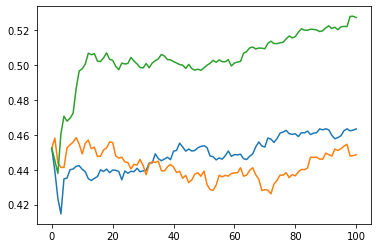

In [20]:
plt.plot(y[:,0])
plt.plot(y[:,1])
plt.plot(y[:,2])


In [12]:
a=np.array([[5],[4]])

In [13]:
a

array([[5],
       [4]])

In [14]:
a[:,0]

array([5, 4])